## Commit Metrics

    Set up the extraction of the data we need with exclusions and functions to get raw data for a single repository or for multiple collections.

In [1]:
import pandas as pd
import numpy as np
import utils, os
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from config import *

outdir = output_directory


repo_urls = glob(os.path.join('./repositories/', '*/'))
collections = utils.init_db(repo_urls, False)

exclude_data_commit = {'type': False, 'branches': False, 'main_branch': False, 'merge': False, 'issue_link': False,
                            'fixes_no': False, 'author_date': False}

exclude_data_file = {'type': False, '_id': False}

exclude_data_info = {'type': False, '_id': False, 'change_set_max': False}

# Single repository to be analysed
# Can require kernel reload to take effect
repo_name = 'dubbo'

def get_single_raw_data(document_type):
    
    db = [db for db in collections if db.name == repo_name ]
    db = db.pop()
    
    if(document_type == 'commits'):
        raw_data = find_commits(db)
    if(document_type == 'files'):
        raw_data = find_files(db)
    if(document_type == 'info'):
        raw_data = find_info(db)
        
    return raw_data
        
def get_raw_data_list(document_type):
    
    raw_data_list = []
    
    for db in collections:
        
        if(document_type == 'commits'):
            raw_data = find_commits(db)
            
        if(document_type == 'files'):
            raw_data = find_files(db)
            
        if(document_type == 'info'):
            raw_data = find_info(db)
            
        raw_data_list.append(raw_data)
        
    return raw_data_list


def find_commits(db):
    raw_data = db.find({'type' : 'commit', 'main_branch': True, 'merge': False }, 
                       projection=exclude_data_commit).sort('committer_date', 1)
    return raw_data

def find_files(db):
    raw_data = db.find({'type' : 'file', 'commit_ids' : { '$exists': 'true', '$ne': [] }}, 
                       projection=exclude_data_file)
    return raw_data

def find_info(db):
    raw_data = db.find({'type' : 'info'}, projection=exclude_data_info)
    
    return raw_data

       The raw data is converted to a list and turned into a Pandas DataFrame object. Rename the column labels for better visibility, set the index to the Date of the commits.

In [2]:
def initialise(commits_df):
    commits_df.rename({'committer_date': 'Commit Date', 'fix_by_msg': 'Fix keyword present', 'fix_only_by_msg': 'Fix indicated only by keyword',
                         'fix_by_issue': 'Issue fixing commit'}, axis=1, inplace=True)
    commits_df = commits_df.set_index('Commit Date')
    return commits_df

### Evolution of commits over time:   
    
    Copy the commits DataFrame and turn the values of False or True for the commit categories into 0 or 1 to get cumulative sums

In [3]:
commits_df = pd.DataFrame(list(get_single_raw_data('commits')))
commits_df = initialise(commits_df)

commits_bool = commits_df[['Fix keyword present', 'Fix indicated only by keyword', 'Issue fixing commit']].copy() 


commits_bool['Fix keyword present'] = commits_bool['Fix keyword present'].astype(int)
commits_bool['Issue fixing commit'] = commits_bool['Issue fixing commit'].astype(int)
commits_bool['Fix indicated only by keyword'] = commits_bool['Fix indicated only by keyword'].astype(int)

commits_sum = pd.DataFrame(commits_bool.cumsum())

#### Plotting the evolution of the fixing commit types by commit date
     
     All figures are saved in the ./figures/directory

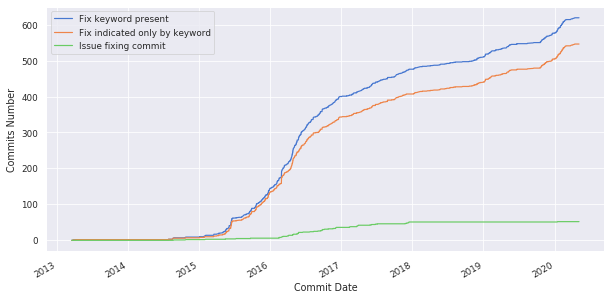

In [4]:
sns.set(rc={'figure.figsize':(10, 5)})
sns.set_palette("muted")
sns.set_context("paper")
sns.axes_style("whitegrid")

fig1 = commits_sum[['Fix keyword present', 'Fix indicated only by keyword', 'Issue fixing commit']].plot()
fig1.set(ylabel='Commits Number')
out1 = fig1.get_figure()
out1.savefig(outdir + repo_name + "_commit_evol.png", dpi=600)

### Commits Frequency

     Copy the DataFrame where the types of commits are indicated by boolean values and indicate in a new column that a missing type is 'Other Commit'. Resample the data to quarterly frequency to show trends and plot the data in a stacked area chart.
    

In [5]:
commits_freq = commits_bool[['Fix keyword present', 'Fix indicated only by keyword', 'Issue fixing commit']].copy()
commits_freq['Other Commits'] = np.where(np.sum(commits_freq, axis=1) == 0, 1, 0)
commits_res = commits_freq.resample('Q').sum()

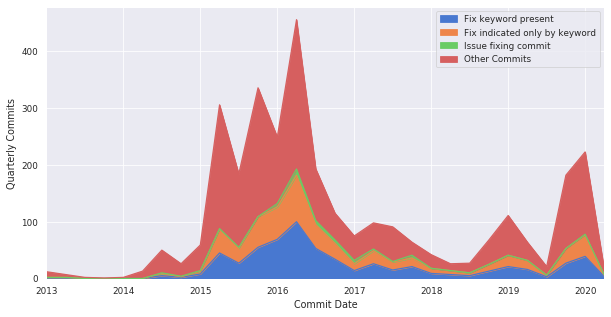

In [6]:
sns.set_palette("muted")
fig2 = commits_res.plot.area(stacked=True)
fig2.set(ylabel='Quarterly Commits')


out2 = fig2.get_figure()
out2.savefig(outdir + repo_name + "_quarterly_freq.png", dpi=600)

## File Metrics



        To get complete metrics for the files in a given repository, this method explodes the file with an array of commits that "touched" it into separate observations and matches the ids with the identified fixing commit ids from the matching commits DataFrame.

In [7]:


def get_files_metrics(raw_files, raw_commits):
 
    file_df = pd.DataFrame(list(raw_files))
    commits_df = initialise(pd.DataFrame(list(raw_commits)))
    #There has to be linked commits to the files
    expl = file_df.explode('commit_ids')

    issue_fixing = commits_df.loc[commits_df['Issue fixing commit'] == True]
    msg_fixing_only = commits_df.loc[commits_df['Fix indicated only by keyword'] == True]
    fix_msg_present = commits_df.loc[commits_df['Fix keyword present'] == True]

    issue_fixing_id_list = issue_fixing['_id'].to_list()
    msg_fixing_only_id_list = msg_fixing_only['_id'].to_list()
    fix_msg_present_id_list = fix_msg_present['_id'].to_list()

    expl['fixed_by_issue'] = expl['commit_ids'].apply(lambda x: any([k in x for k in issue_fixing_id_list]))
    expl['Issue fixing commit count'] = np.where(expl['fixed_by_issue'] == True, 1, 0)

    expl['fixed_by_msg_only'] = expl['commit_ids'].apply(lambda x: any([k in x for k in msg_fixing_only_id_list]))
    expl['Fix indicated only by keyword count'] = np.where(expl['fixed_by_msg_only'] == True, 1, 0)

    expl['fix_msg_present'] = expl['commit_ids'].apply(lambda x: any([k in x for k in fix_msg_present_id_list]))
    expl['Fix keyword present count'] = np.where(expl['fix_msg_present'] == True, 1, 0)
    
    
    files = expl.groupby(['path']).agg({'Issue fixing commit count': 'sum', 'Fix indicated only by keyword count': 'sum', 'Fix keyword present count': 'sum', 'contribs': 'first','minor_con': 'first', 'contrib_exp': 'first', 
                                        'churn': 'first', 'churn_max': 'first','churn_avg': 'first', 'hunks': 'first'})
    
    files.rename({'contribs': 'Contributors', 'minor_con': 'Minor contributors', 'contrib_exp': 'Highest contribution in %',
                         'churn': 'Churn', 'churn_max' : 'Churn max', 'churn_avg' : 'Churn Average', 'hunks' : 'Code Hunks'}, axis=1, inplace=True)
    return files

        Get metrics for all the files in the single repository to be analysed, sort by Issue fixing commit count and save the top 50 files to a csv in ./outputs/ .
        
#### File metrics for single repo by descending issue fix count

In [8]:
raw_files = get_single_raw_data('files')
raw_commits = get_single_raw_data('commits')

files = get_files_metrics(raw_files, raw_commits)
files_head = files.sort_values(by='Issue fixing commit count', ascending=False).head(20)

files_head.to_csv(outdir + repo_name + "_files_head.csv", sep=',', decimal='.')
#files_head.to_latex(repo_name + '_files_head.tex')

files_head

,Issue fixing commit count,Fix indicated only by keyword count,Fix keyword present count,Contributors,Minor contributors,Highest contribution in %,Churn,Churn max,Churn Average,Code Hunks
path,,,,,,,,,,
src/core/core.scale.js,6,60,69,39.0,32.0,28.08,1590,655,6,3.0
src/scales/scale.time.js,6,43,48,28.0,22.0,21.49,815,405,4,2.0
src/controllers/controller.bar.js,5,24,28,21.0,15.0,26.59,434,431,3,4.0
test/specs/scale.logarithmic.tests.js,4,22,27,22.0,18.0,54.11,1163,1561,16,2.0
src/core/core.controller.js,4,51,55,35.0,30.0,32.99,1081,371,4,2.5
src/scales/scale.logarithmic.js,4,25,29,15.0,9.0,31.48,189,643,2,3.0
src/plugins/plugin.tooltip.js,4,39,44,39.0,34.0,25.95,1099,344,7,3.0
src/scales/scale.category.js,3,21,24,15.0,11.0,43.13,111,211,1,2.0
src/controllers/controller.doughnut.js,3,27,30,22.0,17.0,31.66,294,184,2,2.0


        Get overall statistics of the file metrics in a given repository and to a csv in ./outputs/ .
#### Overall file metrics for single repo

In [9]:
repo_files = files.describe()
repo_files = repo_files.round(2)

idx = repo_files.index.rename('Metric')
repo_files = repo_files.set_index(idx)
repo_files.to_csv(outdir + repo_name + "_metrics.csv", sep=',', decimal=',')
#repo_files.to_latex(repo_name + 'metrics.tex')

repo_files

,Issue fixing commit count,Fix indicated only by keyword count,Fix keyword present count,Contributors,Minor contributors,Highest contribution in %,Churn,Churn max,Churn Average,Code Hunks
Metric,,,,,,,,,,
count,909.00,909.00,909.00,593.00,593.00,593.00,909.00,909.00,909.00,909.00
mean,0.09,2.10,2.23,4.02,1.75,78.05,99.75,88.72,30.57,0.89
std,0.51,4.81,5.32,5.11,4.12,24.63,615.01,624.22,449.40,0.92
min,0.00,0.00,0.00,1.00,0.00,19.82,-4.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,1.00,0.00,55.86,0.00,0.00,0.00,0.00
50%,0.00,1.00,1.00,2.00,0.00,91.30,35.00,34.00,9.00,1.00
75%,0.00,2.00,2.00,5.00,2.00,100.00,61.00,60.00,24.00,1.00
max,6.00,60.00,69.00,39.00,34.00,100.00,13544.00,13544.00,13544.00,11.00


            From all the individual repository DataFrames, a massive DataFrame is created with all the files and their respective statistics from all of the repositories. Then, this DataFrame is described and saved to a csv in ./outputs/ .
            

In [10]:
raw_dfs_commits = get_raw_data_list('commits')
raw_dfs_files = get_raw_data_list('files')

ovrl_files_df = []

for raw_commits, raw_files in zip(raw_dfs_commits, raw_dfs_files):
    
    files = get_files_metrics(raw_files, raw_commits)
    ovrl_files_df.append(files)
    

#### Overall file metrics across every repository

In [11]:
df = pd.concat(ovrl_files_df)
ovrl = df.describe()
ovrl = ovrl.round(2)

idx = ovrl.index.rename('Metric')
ovrl = ovrl.set_index(idx)

ovrl.to_csv(outdir + "ovrl_metrics.csv", sep=',', decimal=',')
#ovrl.to_latex('ovrl.tex')

ovrl

,Issue fixing commit count,Fix indicated only by keyword count,Fix keyword present count,Contributors,Minor contributors,Highest contribution in %,Churn,Churn max,Churn Average,Code Hunks
Metric,,,,,,,,,,
count,10970.00,10970.00,10970.00,9637.00,9637.00,9637.00,10970.00,10970.00,10970.00,10970.00
mean,0.79,1.67,3.30,3.40,1.53,82.06,219.00,175.28,50.83,1.48
std,2.99,4.32,9.05,4.22,3.78,20.53,4825.87,4645.10,1544.19,2.67
min,0.00,0.00,0.00,1.00,0.00,17.94,-11077.00,-49.00,-137.00,0.00
25%,0.00,0.00,0.00,1.00,0.00,66.31,16.00,15.00,4.00,1.00
50%,0.00,1.00,1.00,2.00,0.00,91.78,54.00,47.00,12.00,1.00
75%,1.00,2.00,3.00,4.00,2.00,100.00,132.00,106.00,30.00,2.00
max,125.00,184.00,372.00,137.00,134.00,100.00,479807.00,479826.00,159936.00,141.00


        Getting and formating the aggregate information about each repository that was parsed.
        
#### Overall Counts by repository

In [12]:
raw_repos_info = get_raw_data_list('info')

repos_info = []

for repo_info, repo in zip(raw_repos_info, collections):  
    info_df = pd.DataFrame(list(repo_info))
    
    info_df.rename({'commits': 'Commits Number', 'fix_by_msg': 'Fix keyword present', 'fix_only_by_msg': 'Fix indicated only by keyword',
             'fix_by_issue': 'Issue fixing commits', 'change_set_avg' : 'Average number of files committed together',
                    'bug_related_issues' : 'Number of Issues labeled as bug'}, axis=1, inplace=True)
    info_df.index = ['{}'.format(repo.name.capitalize())] * len(info_df)
    repos_info.append(info_df)
    
all_repo_info = pd.concat(repos_info)

all_repo_info = all_repo_info[['Commits Number', 'Fix keyword present', 'Fix indicated only by keyword', 'Issue fixing commits', 'Number of Issues labeled as bug', 'Average number of files committed together']]
all_repo_info = all_repo_info.sort_values(by='Commits Number', ascending=False)

idx = all_repo_info.index.rename('Repos')
all_repo_info = all_repo_info.set_index(idx)
all_repo_info.to_csv(outdir + "ovrl_info.csv", sep=',', decimal=',')
#all_repo_info.to_latex('allrepoinfo.tex')

all_repo_info

,Commits Number,Fix keyword present,Fix indicated only by keyword,Issue fixing commits,Number of Issues labeled as bug,Average number of files committed together
Repos,,,,,,
Netdata,10299,2145,1587,394,1205,2
Hugo,5744,1942,589,693,799,5
Dubbo,4286,827,480,44,120,9
D3,4215,758,456,145,235,3
Moment,3884,677,500,96,252,3
Chart.js,3123,619,546,52,1222,3
Vue,3098,1036,555,94,363,3
Glide,2491,625,373,216,409,7
Puppeteer,1745,707,310,110,201,3
